In [1]:
from __future__ import annotations

from pathlib import Path
import importlib

import numpy as np
import pandas as pd

import src.retina_embeddings_dataset as red

# Ensure the notebook uses the latest loader code without needing a kernel restart.
importlib.reload(red)
load_retina_embeddings_dataset = red.load_retina_embeddings_dataset
select_feature_matrix = red.select_feature_matrix

# --- Config (pick ONE dataset + ONE embeddings file) ---
ROOT = Path.cwd()  # expected: .../Sprint-Project-4-5/Solved

DATASET = "mbrset"  # "mbrset" or "brset"

if DATASET == "mbrset":
    EMBEDDINGS_CSV = ROOT / "data" / "mbrset_embeddings" / "Embeddings_vit_base_mbrset.csv"
    LABELS_CSV = ROOT / "data" / "mbrset_embeddings" / "mbrset_labels" / "labels_mbrset.csv"
    VIEW = "macula"  # "macula" keeps .1/.3 images; "all" keeps everything
else:
    EMBEDDINGS_CSV = ROOT / "data" / "brset_embeddings" / "Embeddings_brset_vit_base_.csv"
    LABELS_CSV = ROOT / "data" / "brset_embeddings" / "brset_labels" / "labels_brset.csv"
    VIEW = "all"

# --- Load + merge embeddings with labels; derive tasks ---
ds = load_retina_embeddings_dataset(
    dataset=DATASET,
    embeddings_csv_path=str(EMBEDDINGS_CSV),
    labels_csv_path=str(LABELS_CSV),
    view=VIEW,
)

df = ds.df
print("Merged rows:", len(df))
print("# embedding dims:", len(ds.feature_cols))

# --- Quick dataset sanity checks / distributions ---
print("\nPatients (unique):", df["patient_id"].nunique(dropna=True) if "patient_id" in df.columns else "<missing>")
if "patient_id" in df.columns:
    per_patient = df["patient_id"].astype(str).value_counts()
    print("Images per patient (min/median/max):", int(per_patient.min()), float(per_patient.median()), int(per_patient.max()))

# Core tasks + common demographics
cols_to_show = [
    "task_any_dr",
    "task_referable",
    "task_3class",
    "sex",
    "age",
    "dr_grade",
    "edema_bin",
]

for c in cols_to_show:
    if c not in df.columns:
        continue
    if c == "age":
        age = pd.to_numeric(df["age"], errors="coerce")
        print(f"\n{c} describe:\n{age.describe()}")
        age_bin = pd.cut(age, bins=[-np.inf, 40, 60, np.inf], labels=["<40", "40-60", ">60"])
        print(f"\nage_bin value_counts:\n{age_bin.value_counts(dropna=False).sort_index()}")
        continue
    vc = df[c].value_counts(dropna=False).sort_index()
    print(f"\n{c} value_counts:\n{vc}")

# Show a small preview of other label columns that *exist* but aren’t used by default tasks.
# (We don’t print everything because BRSET has many optional disease labels.)
exclude = set(cols_to_show) | {"image_name", "image_key", "patient_id"}
extra_binary = red.suggest_binary_target_columns(df, exclude=exclude, min_positives=25, min_negatives=25)
if extra_binary:
    print("\nOther viable binary labels detected (first 12):")
    for col in extra_binary[:12]:
        s = pd.to_numeric(df[col], errors="coerce")
        s = s.where(s.isin([0, 1]))
        vc = s.value_counts(dropna=True)
        pos = int(vc.get(1, 0))
        neg = int(vc.get(0, 0))
        total = pos + neg
        pos_rate = (pos / total) if total else np.nan
        print(f"- {col}: n={total}, pos_rate={pos_rate:.3f}")
else:
    print("\n(No additional binary labels detected with the current thresholds.)")

# --- Feature matrix ---
X = select_feature_matrix(df, ds.feature_cols)
print("\nX shape:", X.shape)

# --- Minimal baselines (patient split, fast sanity-check) ---
# Note: Cell 2 does the proper evaluation (GroupKFold CV) with 5 models.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def _train_test_split_by_patient(
    df_in: pd.DataFrame,
    patient_col: str,
    test_size: float = 0.2,
    seed: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    patients = df_in[patient_col].dropna().astype(str).unique().tolist()
    patients = np.array(patients, dtype=object)
    rng.shuffle(patients)

    n_test = max(1, int(round(len(patients) * test_size)))
    test_patients = set(patients[:n_test].tolist())

    patient_vals = df_in[patient_col].astype(str).to_numpy()
    test_mask = np.array([p in test_patients for p in patient_vals], dtype=bool)
    train_mask = ~test_mask
    return train_mask, test_mask


def _standardize_fit(X_train: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0
    return mean, std


def _standardize_apply(X_in: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (X_in - mean) / std


def _ridge_fit(X_train: np.ndarray, y_train: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    # Adds bias term.
    Xb = np.hstack([X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)])
    # Closed-form: w = (X^T X + a I)^-1 X^T y
    d = Xb.shape[1]
    A = Xb.T @ Xb + alpha * np.eye(d, dtype=Xb.dtype)
    b = Xb.T @ y_train
    w = np.linalg.solve(A, b)
    return w


def _ridge_predict_proba(X_in: np.ndarray, w: np.ndarray) -> np.ndarray:
    Xb = np.hstack([X_in, np.ones((X_in.shape[0], 1), dtype=X_in.dtype)])
    logits = Xb @ w
    # sigmoid
    return 1.0 / (1.0 + np.exp(-logits))


def _safe_auc(y_true: np.ndarray, y_score: np.ndarray) -> float:
    try:
        return float(roc_auc_score(y_true, y_score))
    except Exception:
        return float("nan")


def run_binary_task(task_col: str, patient_col: str = "patient_id") -> None:
    if task_col not in df.columns:
        print(f"\n[skip] Missing column: {task_col}")
        return
    if patient_col not in df.columns:
        print(f"\n[skip] Missing patient column: {patient_col}")
        return

    task_df = df.dropna(subset=[task_col]).copy()
    y = task_df[task_col].astype(int).to_numpy()
    X_task = select_feature_matrix(task_df, ds.feature_cols)

    train_mask, test_mask = _train_test_split_by_patient(task_df, patient_col=patient_col, seed=0)
    X_train, X_test = X_task[train_mask], X_task[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print(f"\n[skip] {task_col}: train/test has a single class in this split")
        return

    # Ridge baseline (numpy-only)
    mean, std = _standardize_fit(X_train)
    X_train_s = _standardize_apply(X_train, mean, std)
    X_test_s = _standardize_apply(X_test, mean, std)

    w = _ridge_fit(X_train_s, y_train.astype(np.float32), alpha=10.0)
    p_ridge = _ridge_predict_proba(X_test_s, w)
    yhat_ridge = (p_ridge >= 0.5).astype(int)

    ridge_acc = float(accuracy_score(y_test, yhat_ridge))
    ridge_bal = float(balanced_accuracy_score(y_test, yhat_ridge))
    ridge_f1 = float(f1_score(y_test, yhat_ridge, zero_division=0))
    ridge_auc = _safe_auc(y_test, p_ridge)

    # Logistic regression baseline (sklearn)
    lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=4000, solver="lbfgs"))
    lr.fit(X_train, y_train)
    p_lr = lr.predict_proba(X_test)[:, 1]
    yhat_lr = (p_lr >= 0.5).astype(int)

    lr_acc = float(accuracy_score(y_test, yhat_lr))
    lr_bal = float(balanced_accuracy_score(y_test, yhat_lr))
    lr_f1 = float(f1_score(y_test, yhat_lr, zero_division=0))
    lr_auc = _safe_auc(y_test, p_lr)

    print(f"\nTask: {task_col}")
    print("test n:", len(y_test), "pos rate:", round(float(y_test.mean()), 4))
    print(f"ridge  | acc={ridge_acc:.4f} bal_acc={ridge_bal:.4f} f1={ridge_f1:.4f} roc_auc={ridge_auc:.4f}")
    print(f"logreg | acc={lr_acc:.4f} bal_acc={lr_bal:.4f} f1={lr_f1:.4f} roc_auc={lr_auc:.4f}")


def run_multiclass_task(task_col: str = "task_3class", patient_col: str = "patient_id") -> None:
    if task_col not in df.columns:
        print(f"\n[skip] Missing column: {task_col}")
        return
    if patient_col not in df.columns:
        print(f"\n[skip] Missing patient column: {patient_col}")
        return

    task_df = df.dropna(subset=[task_col]).copy()
    y = task_df[task_col].astype(int).to_numpy()
    X_task = select_feature_matrix(task_df, ds.feature_cols)

    train_mask, test_mask = _train_test_split_by_patient(task_df, patient_col=patient_col, seed=0)
    X_train, X_test = X_task[train_mask], X_task[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print(f"\n[skip] {task_col}: train/test has too few classes in this split")
        return

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=8000, solver="lbfgs"),
    )
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)

    acc = float(accuracy_score(y_test, yhat))
    bal_acc = float(balanced_accuracy_score(y_test, yhat))
    f1m = float(f1_score(y_test, yhat, average="macro", zero_division=0))

    print(f"\nTask: {task_col} (multiclass)")
    print("test n:", len(y_test))
    print(f"logreg | acc={acc:.4f} bal_acc={bal_acc:.4f} macro_f1={f1m:.4f}")


run_binary_task("task_any_dr")
run_binary_task("task_referable")
run_multiclass_task("task_3class")

Merged rows: 2582
# embedding dims: 768

Patients (unique): 1291
Images per patient (min/median/max): 2 2.0 2

task_any_dr value_counts:
task_any_dr
0    2001
1     581
Name: count, dtype: Int64

task_referable value_counts:
task_referable
0    2131
1     451
Name: count, dtype: Int64

task_3class value_counts:
task_3class
0       1856
1        478
2        103
<NA>     145
Name: count, dtype: Int64

sex value_counts:
sex
0    1680
1     902
Name: count, dtype: int64

age describe:
count    2576.000000
mean       61.348602
std        11.460645
min         3.000000
25%        55.000000
50%        63.000000
75%        69.000000
max        88.000000
Name: age, dtype: float64

age_bin value_counts:
age
<40       110
40-60    1020
>60      1446
NaN         6
Name: count, dtype: int64

dr_grade value_counts:
dr_grade
0.0    1856
1.0     147
2.0     290
3.0      41
4.0     103
NaN     145
Name: count, dtype: int64

edema_bin value_counts:
edema_bin
0.0    2218
1.0     229
NaN     135
Name: co

In [2]:
# --- Proper models (GroupKFold by patient) ---
import importlib
from pathlib import Path

import numpy as np
import src.retina_evaluation as reval

importlib.reload(reval)

# Choose which tasks to run (this evaluator is binary-only)
TASKS = ["task_any_dr", "task_referable"]
MODELS = ["logreg", "rf", "mlp", "xgb", "lgbm"]

all_summaries = []
all_oof = []

for task in TASKS:
    res = reval.evaluate_binary_models_groupkfold(
        df=df,
        feature_cols=ds.feature_cols,
        label_col=task,
        group_col="patient_id",
        model_names=MODELS,
        n_splits=5,
        seed=0,
    )
    s = res.summary.copy()
    s.insert(0, "task", task)
    all_summaries.append(s)
    all_oof.append(res.oof)

summary_df = pd.concat(all_summaries, ignore_index=True)
oof_df = pd.concat(all_oof, ignore_index=True)

print("\n=== Cross-validated summary (patient-level GroupKFold) ===")
display(summary_df)

# --- CV stability quick look (high mean + tiny std is good; big std can indicate instability) ---
stability_cols = [
    "task",
    "model",
    "roc_auc_mean",
    "roc_auc_std",
    "pr_auc_mean",
    "pr_auc_std",
    "balanced_accuracy_mean",
    "balanced_accuracy_std",
    "f1_mean",
    "f1_std",
    "brier_mean",
    "brier_std",
]
stability_cols = [c for c in stability_cols if c in summary_df.columns]
if stability_cols:
    print("\n=== CV stability (mean ± std) ===")
    display(summary_df.loc[:, stability_cols].sort_values(["task", "roc_auc_mean"], ascending=[True, False]))

# --- Leakage / overfitting sanity check: label permutation ---
# If the pipeline is leaking information, even permuted labels may score >> 0.5 ROC-AUC.
RUN_PERMUTATION_CHECK = True
if RUN_PERMUTATION_CHECK:
    from numpy.random import default_rng

    def _permuted_auc(task_col: str, model_name: str = "lgbm", n_perm: int = 2, seed: int = 0) -> list[float]:
        aucs: list[float] = []
        rng = default_rng(seed)
        work = df.dropna(subset=[task_col, "patient_id"]).copy()
        y = work[task_col].astype(int).to_numpy()
        for i in range(n_perm):
            work_perm = work.copy()
            work_perm[task_col] = rng.permutation(y)
            r = reval.evaluate_binary_models_groupkfold(
                df=work_perm,
                feature_cols=ds.feature_cols,
                label_col=task_col,
                group_col="patient_id",
                model_names=[model_name],
                n_splits=5,
                seed=seed + 100 + i,
            )
            aucs.append(float(r.summary.iloc[0]["roc_auc_mean"]))
        return aucs

    print("\n=== Permutation check (expected ~0.5 ROC-AUC) ===")
    for task in TASKS:
        try:
            aucs = _permuted_auc(task, model_name="lgbm", n_perm=2, seed=0)
            print(f"{task}: lgbm permuted roc_auc_mean -> {aucs}")
        except Exception as e:
            print(f"{task}: permutation check failed: {e}")

# --- Fairness / subgroup slices (sex + age bins) ---
# Uses out-of-fold predictions so we slice metrics on held-out data.
subgroup_tables = []

for task in TASKS:
    print(f"\n=== Subgroup report for: {task} ===")
    task_oof = oof_df[oof_df["label_col"] == task]

    # Pick best model by roc_auc_mean (fallback to first if all NaN)
    best = (
        summary_df[summary_df["task"] == task]
        .sort_values(by="roc_auc_mean", ascending=False, na_position="last")
        .iloc[0]["model"]
    )
    print("Best model:", best)

    if "sex" in task_oof.columns and task_oof["sex"].notna().any():
        sex_report = reval.fairness_report_binary(oof=task_oof, model_name=best, by="sex")
        sex_report.insert(0, "task", task)
        print("\nBy sex:")
        display(sex_report)
        subgroup_tables.append(sex_report)

    if "age" in task_oof.columns and task_oof["age"].notna().any():
        age_report = reval.fairness_report_binary(oof=task_oof, model_name=best, by="age_bin")
        age_report.insert(0, "task", task)
        print("\nBy age_bin (<40 / 40-60 / >60):")
        display(age_report)
        subgroup_tables.append(age_report)

# --- Export results for sharing ---
RESULTS_DIR = Path.cwd() / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

summary_path = RESULTS_DIR / f"summary_{DATASET}_{EMBEDDINGS_CSV.stem}.csv"
oof_path = RESULTS_DIR / f"oof_{DATASET}_{EMBEDDINGS_CSV.stem}.parquet"

summary_df.to_csv(summary_path, index=False)

# Parquet keeps this file manageable; requires pyarrow (installed via requirements.txt)
oof_df.to_parquet(oof_path, index=False)

if subgroup_tables:
    subgroup_df = pd.concat(subgroup_tables, ignore_index=True)
    subgroup_path = RESULTS_DIR / f"subgroups_{DATASET}_{EMBEDDINGS_CSV.stem}.csv"
    subgroup_df.to_csv(subgroup_path, index=False)

print("\nSaved:")
print("-", summary_path)
print("-", oof_path)
if subgroup_tables:
    print("-", subgroup_path)


=== Cross-validated summary (patient-level GroupKFold) ===


,task,model,n_mean,pos_rate_mean,accuracy_mean,balanced_accuracy_mean,f1_mean,brier_mean,roc_auc_mean,pr_auc_mean,n_std,pos_rate_std,accuracy_std,balanced_accuracy_std,f1_std,brier_std,roc_auc_std,pr_auc_std
0,task_any_dr,lgbm,516.4,0.225017,0.818353,0.617616,0.384448,0.170580,0.739555,0.551322,0.894427,0.022711,0.015286,0.010484,0.026096,0.016073,0.002158,0.039220
1,task_any_dr,xgb,516.4,0.225017,0.820291,0.626955,0.407316,0.157251,0.738129,0.543374,0.894427,0.022711,0.016161,0.013765,0.033344,0.015884,0.010012,0.036594
2,task_any_dr,mlp,516.4,0.225017,0.802471,0.642281,0.442246,0.156097,0.720756,0.517398,0.894427,0.022711,0.018279,0.017205,0.033508,0.018074,0.025378,0.031455
3,task_any_dr,rf,516.4,0.225017,0.780403,0.515983,0.067392,0.156231,0.712179,0.485430,0.894427,0.022711,0.019688,0.007350,0.026664,0.012082,0.016652,0.035823
4,task_any_dr,logreg,516.4,0.225017,0.724227,0.655863,0.463156,0.221040,0.694844,0.449996,0.894427,0.022711,0.017681,0.032761,0.054817,0.018869,0.022635,0.028326
5,task_referable,xgb,516.4,0.174660,0.859421,0.628175,0.403275,0.120627,0.797404,0.569644,0.894427,0.021030,0.013475,0.008852,0.024409,0.015736,0.025456,0.042519
6,task_referable,mlp,516.4,0.174660,0.859416,0.655743,0.457836,0.112785,0.791551,0.542703,0.894427,0.021030,0.017530,0.027647,0.057763,0.012890,0.020843,0.060973
7,task_referable,lgbm,516.4,0.174660,0.856704,0.614275,0.370249,0.134587,0.789471,0.558562,0.894427,0.021030,0.013154,0.011497,0.031716,0.014262,0.020689,0.042371
8,task_referable,rf,516.4,0.174660,0.829212,0.512821,0.051623,0.124009,0.768518,0.512938,0.894427,0.021030,0.021183,0.003213,0.009262,0.011599,0.024319,0.038079
9,task_referable,logreg,516.4,0.174660,0.788155,0.686220,0.464337,0.172402,0.751556,0.488048,0.894427,0.021030,0.014019,0.029019,0.054340,0.006911,0.018348,0.063097



=== CV stability (mean ± std) ===


,task,model,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,balanced_accuracy_mean,balanced_accuracy_std,f1_mean,f1_std,brier_mean,brier_std
0,task_any_dr,lgbm,0.739555,0.002158,0.551322,0.039220,0.617616,0.010484,0.384448,0.026096,0.170580,0.016073
1,task_any_dr,xgb,0.738129,0.010012,0.543374,0.036594,0.626955,0.013765,0.407316,0.033344,0.157251,0.015884
2,task_any_dr,mlp,0.720756,0.025378,0.517398,0.031455,0.642281,0.017205,0.442246,0.033508,0.156097,0.018074
3,task_any_dr,rf,0.712179,0.016652,0.485430,0.035823,0.515983,0.007350,0.067392,0.026664,0.156231,0.012082
4,task_any_dr,logreg,0.694844,0.022635,0.449996,0.028326,0.655863,0.032761,0.463156,0.054817,0.221040,0.018869
5,task_referable,xgb,0.797404,0.025456,0.569644,0.042519,0.628175,0.008852,0.403275,0.024409,0.120627,0.015736
6,task_referable,mlp,0.791551,0.020843,0.542703,0.060973,0.655743,0.027647,0.457836,0.057763,0.112785,0.012890
7,task_referable,lgbm,0.789471,0.020689,0.558562,0.042371,0.614275,0.011497,0.370249,0.031716,0.134587,0.014262
8,task_referable,rf,0.768518,0.024319,0.512938,0.038079,0.512821,0.003213,0.051623,0.009262,0.124009,0.011599
9,task_referable,logreg,0.751556,0.018348,0.488048,0.063097,0.686220,0.029019,0.464337,0.054340,0.172402,0.006911



=== Permutation check (expected ~0.5 ROC-AUC) ===
task_any_dr: lgbm permuted roc_auc_mean -> [0.47981114854948154, 0.481147980430823]
task_referable: lgbm permuted roc_auc_mean -> [0.4930510825764844, 0.5036694648140402]

=== Subgroup report for: task_any_dr ===
Best model: lgbm

By sex:


,task,model,group_by,group,n,pos_rate,accuracy,f1,roc_auc
0,task_any_dr,lgbm,sex,0,1680,0.211310,0.825000,0.366379,0.728040
1,task_any_dr,lgbm,sex,1,902,0.250554,0.805987,0.414716,0.753751



By age_bin (<40 / 40-60 / >60):


,task,model,group_by,group,n,pos_rate,accuracy,f1,roc_auc
1,task_any_dr,lgbm,age_bin,40-60,950,0.273684,0.797895,0.445087,0.789370
0,task_any_dr,lgbm,age_bin,<40,98,0.112245,0.867347,0.235294,0.562173
2,task_any_dr,lgbm,age_bin,>60,1528,0.202880,0.827880,0.340852,0.707974



=== Subgroup report for: task_referable ===
Best model: xgb

By sex:


,task,model,group_by,group,n,pos_rate,accuracy,f1,roc_auc
0,task_referable,xgb,sex,0,1680,0.155952,0.869643,0.368876,0.799344
1,task_referable,xgb,sex,1,902,0.209534,0.840355,0.450382,0.787707



By age_bin (<40 / 40-60 / >60):


,task,model,group_by,group,n,pos_rate,accuracy,f1,roc_auc
1,task_referable,xgb,age_bin,40-60,950,0.200000,0.857895,0.482759,0.840048
0,task_referable,xgb,age_bin,<40,98,0.102041,0.867347,0.133333,0.714773
2,task_referable,xgb,age_bin,>60,1528,0.164267,0.859293,0.354354,0.766079



Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\summary_mbrset_Embeddings_vit_base_mbrset.csv
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\oof_mbrset_Embeddings_vit_base_mbrset.parquet
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\subgroups_mbrset_Embeddings_vit_base_mbrset.csv


In [8]:
# --- Sweep: evaluate ALL embeddings CSVs ---
from pathlib import Path

import pandas as pd

from src.retina_benchmark import run_embeddings_sweep

ROOT = Path.cwd()

# Keep the sweep "crystal clear" by default:
# - Compare embeddings on the core clinical tasks only
# - Use patient-level CV (GroupKFold) and simple/regularized models in quick mode
SWEEP_MODE = "full"  # "quick" (fast) or "full" (slower)
TASK_PRESET = "clinical"  # "clinical" or "clinical_plus_risk" (risk-factor targets)
TASK_MODE = "given"  # "given" or "given_plus_auto" (auto-discovers extra binary targets)
N_SPLITS = 5

MODELS_QUICK = ["logreg", "lgbm"]
MODELS_FULL = ["logreg", "rf", "mlp", "xgb", "lgbm"]
MODEL_NAMES = MODELS_QUICK if SWEEP_MODE == "quick" else MODELS_FULL

print("\nSweep models:", MODEL_NAMES)
print("Note: the sweep is binary-only; task_3class is handled separately in Cell 1.")

CORE_TASKS = ["task_any_dr", "task_referable"]

RISK_TASKS_MBRSET = [
    "insulin",
    "oraltreatment_dm",
    "systemic_hypertension",
    "smoking",
    "obesity",
    "vascular_disease",
    "nephropathy",
    "neuropathy",
    "diabetic_foot",
    "alcohol_consumption",
]

RISK_TASKS_BRSET = [
    "diabetes",
    "insuline",
    "macular_edema",
    "hypertensive_retinopathy",
    "vascular_occlusion",
    "amd",
    "hemorrhage",
    "drusens",
    "retinal_detachment",
    "myopic_fundus",
    "increased_cup_disc",
    "other",
    "scar",
    "nevus",
]

CONFIGS = [
    {
        "dataset": "mbrset",
        "embeddings_dir": ROOT / "data" / "mbrset_embeddings",
        "labels_csv": ROOT / "data" / "mbrset_embeddings" / "mbrset_labels" / "labels_mbrset.csv",
        "view": "macula",
        "tasks": CORE_TASKS + (RISK_TASKS_MBRSET if TASK_PRESET == "clinical_plus_risk" else []),
    },
    {
        "dataset": "brset",
        "embeddings_dir": ROOT / "data" / "brset_embeddings",
        "labels_csv": ROOT / "data" / "brset_embeddings" / "brset_labels" / "labels_brset.csv",
        "view": "all",
        "tasks": CORE_TASKS + (RISK_TASKS_BRSET if TASK_PRESET == "clinical_plus_risk" else []),
    },
]

sweep_summaries = []
sweep_subgroups = []

for cfg in CONFIGS:
    print(
        f"\n=== Running sweep: {cfg['dataset']} ({SWEEP_MODE}, task_preset={TASK_PRESET}, task_mode={TASK_MODE}) ==="
    )

    summary_df, subgroup_df = run_embeddings_sweep(
        dataset=cfg["dataset"],
        embeddings_dir=cfg["embeddings_dir"],
        labels_csv_path=cfg["labels_csv"],
        view=cfg["view"],
        tasks=cfg["tasks"],
        task_mode=TASK_MODE,
        model_names=MODEL_NAMES,
        n_splits=N_SPLITS,
        seed=0,
        results_dir=ROOT / "results" / "sweeps" / cfg["dataset"],
        save_oof=False,
    )

    sweep_summaries.append(summary_df)
    if not subgroup_df.empty:
        sweep_subgroups.append(subgroup_df)

all_summary = pd.concat(sweep_summaries, ignore_index=True)
all_subgroups = pd.concat(sweep_subgroups, ignore_index=True) if sweep_subgroups else pd.DataFrame()

print("\n=== Sweep summary (first 20 rows) ===")
display(all_summary.head(20))

# Best embeddings per task (by model best ROC-AUC mean)
if not all_summary.empty and "roc_auc_mean" in all_summary.columns:
    best_per_task = (
        all_summary.sort_values(["dataset", "task", "roc_auc_mean"], ascending=[True, True, False])
        .groupby(["dataset", "task"], as_index=False)
        .head(1)
        .loc[:, ["dataset", "task", "embeddings", "model", "roc_auc_mean", "pr_auc_mean", "balanced_accuracy_mean"]]
    )
    print("\n=== Best (dataset, task) ===")
    display(best_per_task)

print("\nSweep outputs written under:")
print("-", ROOT / "results" / "sweeps")


Sweep models: ['logreg', 'rf', 'mlp', 'xgb', 'lgbm']
Note: the sweep is binary-only; task_3class is handled separately in Cell 1.

=== Running sweep: mbrset (full, task_preset=clinical, task_mode=given) ===

=== Running sweep: brset (full, task_preset=clinical, task_mode=given) ===

=== Sweep summary (first 20 rows) ===


,dataset,embeddings,task,model,n_mean,pos_rate_mean,accuracy_mean,balanced_accuracy_mean,f1_mean,brier_mean,...,pr_auc_mean,n_std,pos_rate_std,accuracy_std,balanced_accuracy_std,f1_std,brier_std,roc_auc_std,pr_auc_std,elapsed_seconds
0,mbrset,Embeddings_convnextv2_base_mbrset,task_any_dr,lgbm,516.4,0.225017,0.830741,0.664318,0.487875,0.153235,...,0.634013,0.894427,0.022711,0.020355,0.032439,0.067003,0.021895,0.014103,0.059944,518.189076
1,mbrset,Embeddings_convnextv2_base_mbrset,task_any_dr,xgb,516.4,0.225017,0.831520,0.668094,0.495039,0.137912,...,0.641202,0.894427,0.022711,0.017024,0.033030,0.066950,0.018424,0.013195,0.062644,518.189076
2,mbrset,Embeddings_convnextv2_base_mbrset,task_any_dr,mlp,516.4,0.225017,0.828423,0.685169,0.525587,0.133436,...,0.622771,0.894427,0.022711,0.017576,0.027496,0.055404,0.019451,0.026377,0.072495,518.189076
3,mbrset,Embeddings_convnextv2_base_mbrset,task_any_dr,rf,516.4,0.225017,0.818747,0.611678,0.365606,0.134579,...,0.610895,0.894427,0.022711,0.025199,0.035671,0.087856,0.011047,0.017762,0.062069,518.189076
4,mbrset,Embeddings_convnextv2_base_mbrset,task_any_dr,logreg,516.4,0.225017,0.762592,0.687066,0.509211,0.191174,...,0.574541,0.894427,0.022711,0.008990,0.021186,0.048636,0.008080,0.017798,0.057348,518.189076
5,mbrset,Embeddings_convnextv2_base_mbrset,task_referable,xgb,516.4,0.174660,0.881877,0.701258,0.554067,0.100868,...,0.671609,0.894427,0.021030,0.019598,0.035337,0.069164,0.014939,0.028507,0.072327,495.905695
6,mbrset,Embeddings_convnextv2_base_mbrset,task_referable,lgbm,516.4,0.174660,0.879553,0.690945,0.533697,0.111750,...,0.662784,0.894427,0.021030,0.017761,0.041903,0.081706,0.014555,0.027136,0.075789,495.905695
7,mbrset,Embeddings_convnextv2_base_mbrset,task_referable,rf,516.4,0.174660,0.862910,0.626212,0.397464,0.102133,...,0.639098,0.894427,0.021030,0.023680,0.035508,0.084154,0.012641,0.034395,0.080018,495.905695
8,mbrset,Embeddings_convnextv2_base_mbrset,task_referable,mlp,516.4,0.174660,0.878398,0.717529,0.570842,0.098971,...,0.650347,0.894427,0.021030,0.014027,0.038679,0.065062,0.011396,0.029565,0.058191,495.905695
9,mbrset,Embeddings_convnextv2_base_mbrset,task_referable,logreg,516.4,0.174660,0.840053,0.745118,0.564844,0.127919,...,0.613609,0.894427,0.021030,0.018240,0.036573,0.065179,0.011174,0.037571,0.080520,495.905695



=== Best (dataset, task) ===


,dataset,task,embeddings,model,roc_auc_mean,pr_auc_mean,balanced_accuracy_mean
100,brset,task_any_dr,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.942177,0.745978,0.739768
105,brset,task_referable,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.953945,0.768185,0.758076
0,mbrset,task_any_dr,Embeddings_convnextv2_base_mbrset,lgbm,0.810044,0.634013,0.664318
35,mbrset,task_referable,Embeddings_mbrset_RETFound_dinov2_shanghai,xgb,0.858422,0.683263,0.702942



Sweep outputs written under:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\sweeps


Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\best_model_per_embedding_task.csv

=== Highest fold-to-fold variation (best model per embedding) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,roc_auc_ci95,pr_auc_mean
0,brset,task_any_dr,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.942177,0.015863,0.013904,0.745978
8,brset,task_any_dr,Embeddings_brset_dinov3_convnext_base,xgb,0.906995,0.013639,0.011955,0.617898
4,brset,task_any_dr,Embeddings_brset_RETFound_mae_shanghai,lgbm,0.902474,0.011622,0.010187,0.542961
12,brset,task_any_dr,Embeddings_brset_vit_base_,xgb,0.900717,0.011381,0.009976,0.568696
6,brset,task_any_dr,Embeddings_brset_convnextv2_base_,xgb,0.921162,0.010631,0.009319,0.663447
2,brset,task_any_dr,Embeddings_brset_RETFound_mae_natureCFP,xgb,0.898957,0.007712,0.006760,0.526810
10,brset,task_any_dr,Embeddings_brset_dinov3_vitb16,xgb,0.938751,0.007022,0.006155,0.730741
9,brset,task_referable,Embeddings_brset_dinov3_convnext_base,xgb,0.923944,0.010336,0.009060,0.646298
3,brset,task_referable,Embeddings_brset_RETFound_mae_natureCFP,lgbm,0.901782,0.009627,0.008439,0.533026
1,brset,task_referable,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.953945,0.008902,0.007803,0.768185



Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\prob_best_under_uncertainty.csv

=== Rank stability: P(best) under Normal(mean,std) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,p_best_mc
0,brset,task_any_dr,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.942177,0.015863,0.5676
1,brset,task_any_dr,Embeddings_brset_dinov3_vitb16,xgb,0.938751,0.007022,0.3894
2,brset,task_any_dr,Embeddings_brset_convnextv2_base_,xgb,0.921162,0.010631,0.0362
3,brset,task_any_dr,Embeddings_brset_dinov3_convnext_base,xgb,0.906995,0.013639,0.0058
4,brset,task_any_dr,Embeddings_brset_RETFound_mae_shanghai,lgbm,0.902474,0.011622,0.0006
5,brset,task_any_dr,Embeddings_brset_vit_base_,xgb,0.900717,0.011381,0.0004
6,brset,task_any_dr,Embeddings_brset_RETFound_mae_natureCFP,xgb,0.898957,0.007712,0.0000
7,brset,task_referable,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.953945,0.008902,0.7058
8,brset,task_referable,Embeddings_brset_dinov3_vitb16,lgbm,0.947889,0.005873,0.2710
9,brset,task_referable,Embeddings_brset_convnextv2_base_,lgbm,0.933936,0.008299,0.0190



=== Most ambiguous winners (small P(best) margin) ===


,dataset,task,p_best_top1,p_best_top2,p_best_margin,top1_embeddings,top2_embeddings
3,mbrset,task_referable,0.3694,0.3634,0.0060,Embeddings_convnextv2_base_mbrset,Embeddings_mbrset_RETFound_dinov2_shanghai
0,brset,task_any_dr,0.5676,0.3894,0.1782,Embeddings_brset_RETFound_dinov2_shanghai,Embeddings_brset_dinov3_vitb16
2,mbrset,task_any_dr,0.6136,0.2814,0.3322,Embeddings_convnextv2_base_mbrset,Embeddings_mbrset_dinov3_vitb16
1,brset,task_referable,0.7058,0.2710,0.4348,Embeddings_brset_RETFound_dinov2_shanghai,Embeddings_brset_dinov3_vitb16


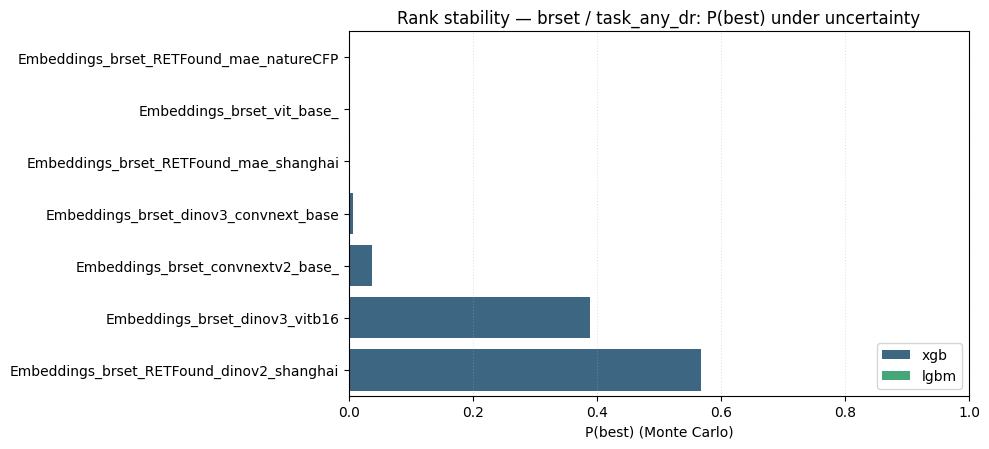

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\pbest_brset_task_any_dr.png


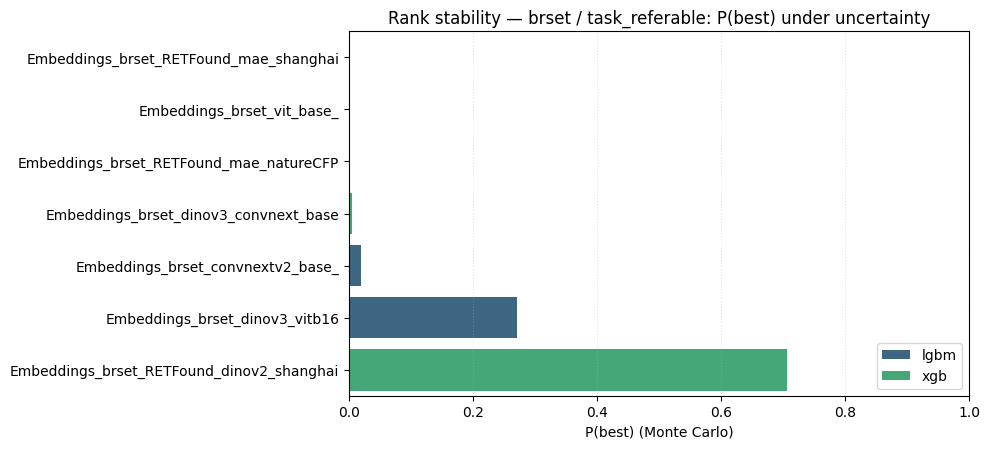

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\pbest_brset_task_referable.png


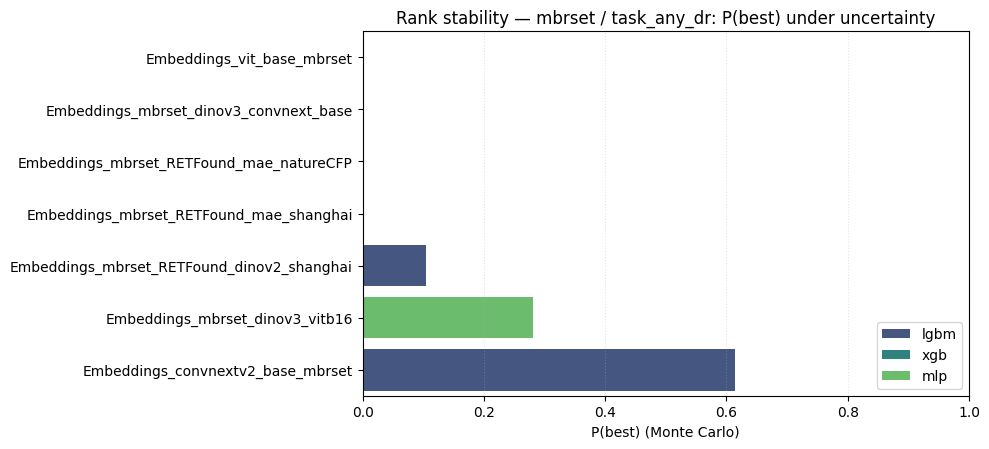

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\pbest_mbrset_task_any_dr.png


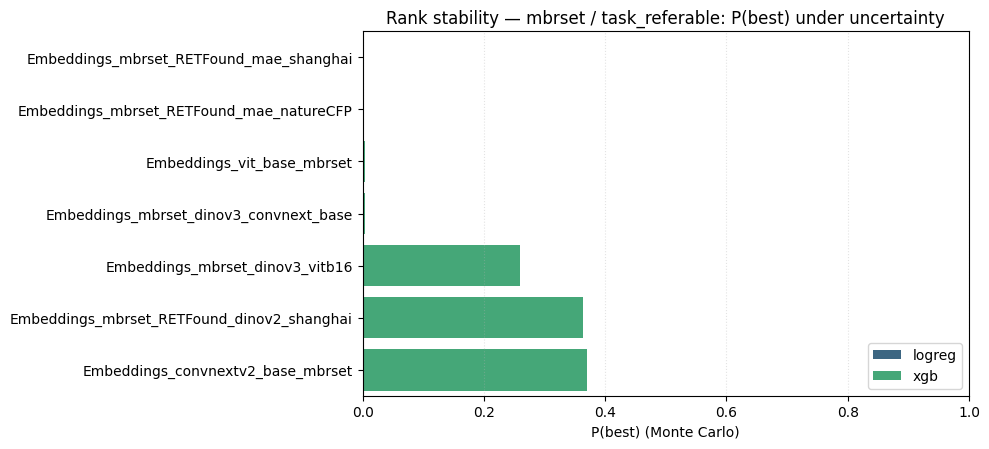

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\pbest_mbrset_task_referable.png

=== Top 5: brset / task_any_dr (best model per embedding) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,roc_auc_ci95,pr_auc_mean,balanced_accuracy_mean
0,brset,task_any_dr,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.942177,0.015863,0.013904,0.745978,0.739768
10,brset,task_any_dr,Embeddings_brset_dinov3_vitb16,xgb,0.938751,0.007022,0.006155,0.730741,0.721687
6,brset,task_any_dr,Embeddings_brset_convnextv2_base_,xgb,0.921162,0.010631,0.009319,0.663447,0.702305
8,brset,task_any_dr,Embeddings_brset_dinov3_convnext_base,xgb,0.906995,0.013639,0.011955,0.617898,0.666962
4,brset,task_any_dr,Embeddings_brset_RETFound_mae_shanghai,lgbm,0.902474,0.011622,0.010187,0.542961,0.621129


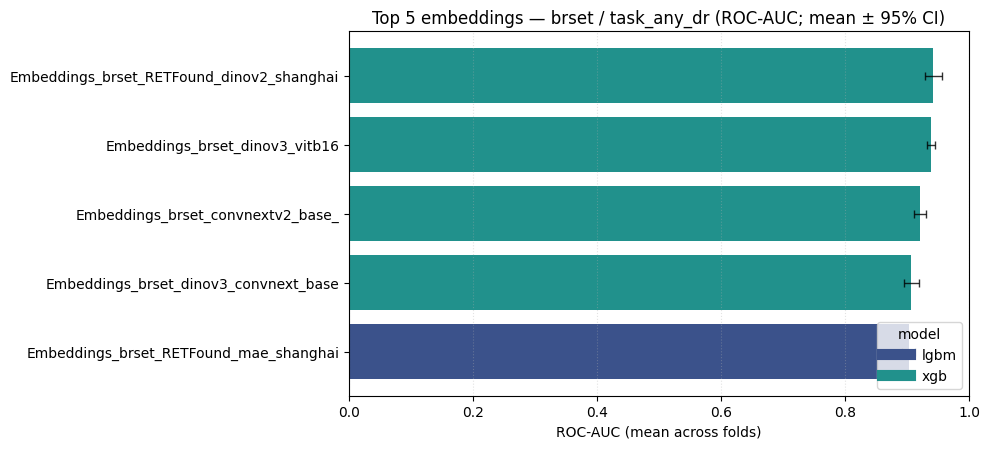

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\top5_brset_task_any_dr_roc_auc_ci95.png

=== Top 5: brset / task_referable (best model per embedding) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,roc_auc_ci95,pr_auc_mean,balanced_accuracy_mean
1,brset,task_referable,Embeddings_brset_RETFound_dinov2_shanghai,xgb,0.953945,0.008902,0.007803,0.768185,0.758076
11,brset,task_referable,Embeddings_brset_dinov3_vitb16,lgbm,0.947889,0.005873,0.005147,0.749246,0.724914
7,brset,task_referable,Embeddings_brset_convnextv2_base_,lgbm,0.933936,0.008299,0.007274,0.688671,0.712780
9,brset,task_referable,Embeddings_brset_dinov3_convnext_base,xgb,0.923944,0.010336,0.009060,0.646298,0.685200
13,brset,task_referable,Embeddings_brset_vit_base_,xgb,0.913858,0.004466,0.003915,0.605497,0.642923


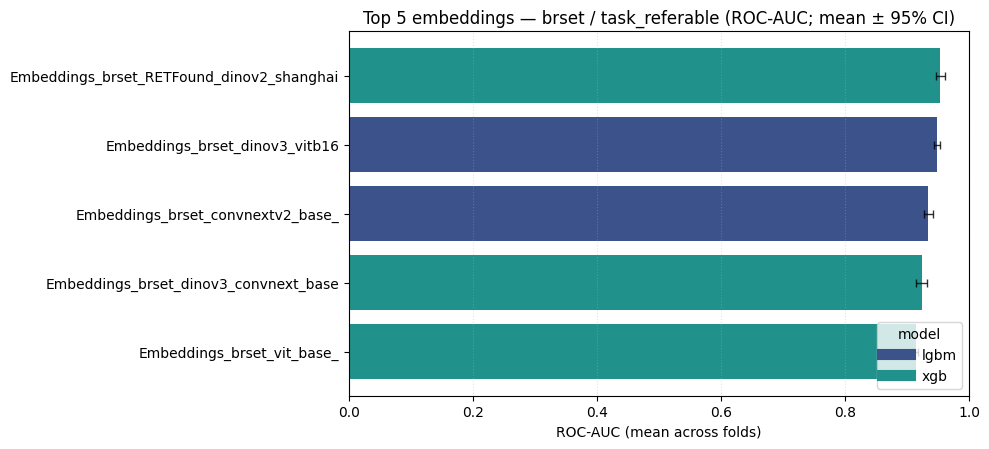

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\top5_brset_task_referable_roc_auc_ci95.png

=== Top 5: mbrset / task_any_dr (best model per embedding) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,roc_auc_ci95,pr_auc_mean,balanced_accuracy_mean
14,mbrset,task_any_dr,Embeddings_convnextv2_base_mbrset,lgbm,0.810044,0.014103,0.012362,0.634013,0.664318
24,mbrset,task_any_dr,Embeddings_mbrset_dinov3_vitb16,mlp,0.794692,0.026475,0.023207,0.636820,0.694418
16,mbrset,task_any_dr,Embeddings_mbrset_RETFound_dinov2_shanghai,lgbm,0.790303,0.015005,0.013152,0.634357,0.660994
22,mbrset,task_any_dr,Embeddings_mbrset_dinov3_convnext_base,xgb,0.740313,0.014188,0.012436,0.554406,0.623547
26,mbrset,task_any_dr,Embeddings_vit_base_mbrset,lgbm,0.739555,0.002158,0.001891,0.551322,0.617616


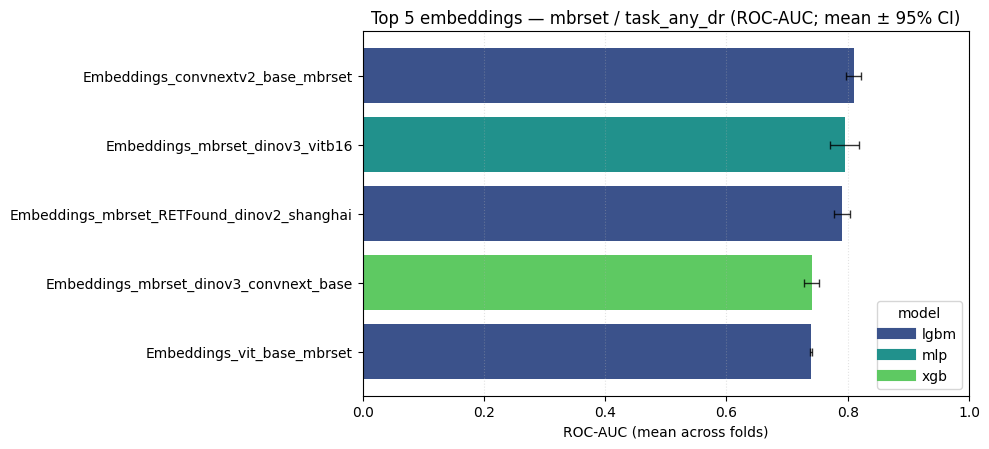

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\top5_mbrset_task_any_dr_roc_auc_ci95.png

=== Top 5: mbrset / task_referable (best model per embedding) ===


,dataset,task,embeddings,model,roc_auc_mean,roc_auc_std,roc_auc_ci95,pr_auc_mean,balanced_accuracy_mean
17,mbrset,task_referable,Embeddings_mbrset_RETFound_dinov2_shanghai,xgb,0.858422,0.014645,0.012837,0.683263,0.702942
25,mbrset,task_referable,Embeddings_mbrset_dinov3_vitb16,xgb,0.855500,0.011896,0.010427,0.678046,0.702830
15,mbrset,task_referable,Embeddings_convnextv2_base_mbrset,xgb,0.854204,0.028507,0.024987,0.671609,0.701258
23,mbrset,task_referable,Embeddings_mbrset_dinov3_convnext_base,xgb,0.811264,0.018931,0.016594,0.599999,0.644441
27,mbrset,task_referable,Embeddings_vit_base_mbrset,xgb,0.797404,0.025456,0.022313,0.569644,0.628175


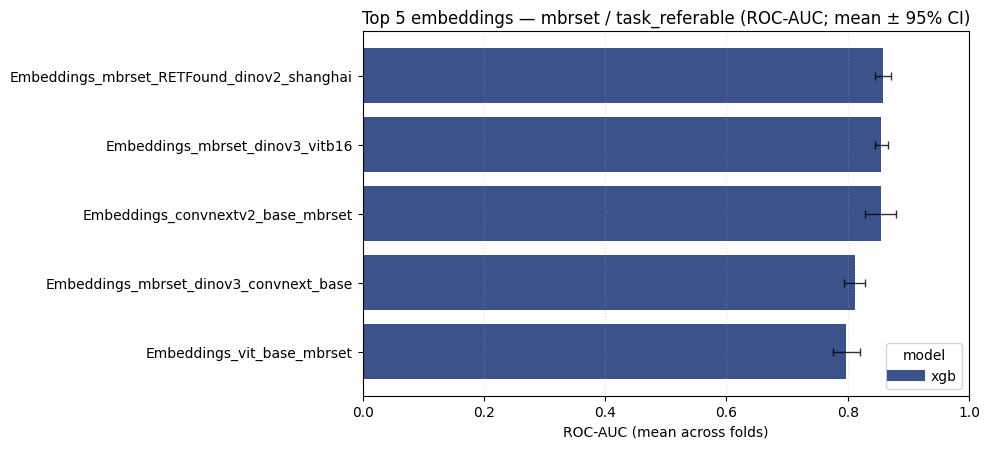

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\top5_mbrset_task_referable_roc_auc_ci95.png

=== Cross-dataset leaderboard (by embedding family) ===


,embedding_family,task,roc_auc_mean,pr_auc_mean,datasets_covered
10,dinov3_vitb16,task_any_dr,0.866721,0.683781,2
0,RETFound_dinov2_shanghai,task_any_dr,0.866240,0.690167,2
6,convnextv2_base,task_any_dr,0.865603,0.648730,2
8,dinov3_convnext_base,task_any_dr,0.823654,0.586152,2
12,vit_base,task_any_dr,0.820136,0.560009,2
2,RETFound_mae_natureCFP,task_any_dr,0.813176,0.519143,2
4,RETFound_mae_shanghai,task_any_dr,0.808358,0.523763,2
1,RETFound_dinov2_shanghai,task_referable,0.906184,0.725724,2
11,dinov3_vitb16,task_referable,0.901694,0.713646,2
7,convnextv2_base,task_referable,0.894070,0.680140,2


Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\leaderboards\cross_dataset_leaderboard.csv


In [12]:
# --- Leaderboards + plots from sweep outputs ---
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ROOT = Path.cwd()
LEADER_DIR = ROOT / "results" / "leaderboards"
LEADER_DIR.mkdir(parents=True, exist_ok=True)


def _normalize_embedding_name(stem: str) -> str:
    s = stem
    for prefix in ("Embeddings_brset_", "Embeddings_mbrset_", "Embeddings_"):
        if s.startswith(prefix):
            s = s[len(prefix) :]
    for suffix in ("_mbrset", "_brset"):
        if s.endswith(suffix):
            s = s[: -len(suffix)]
    return s.strip("_")


def _load_sweep_summaries_from_disk() -> pd.DataFrame:
    sweep_root = ROOT / "results" / "sweeps"
    if not sweep_root.exists():
        return pd.DataFrame()

    csvs = list(sweep_root.glob("**/summary_*.csv"))
    if not csvs:
        return pd.DataFrame()

    parts = [pd.read_csv(p) for p in csvs]
    return pd.concat(parts, ignore_index=True)


def _plot_topk_with_errorbars(
    sub: pd.DataFrame,
    *,
    dataset: str,
    task: str,
    top_k: int,
    out_dir: Path,
    metric_mean: str = "roc_auc_mean",
    metric_err: str = "roc_auc_ci95",
    title_suffix: str = "ROC-AUC",
    file_suffix: str = "roc_auc",
    xlim: tuple[float, float] | None = (0.0, 1.0),
    show_errorbars: bool = True,
    err_label: str = "95% CI",
) -> Path | None:
    if sub.empty:
        return None
    if metric_mean not in sub.columns:
        return None

    plot_df = sub.dropna(subset=[metric_mean]).head(top_k).copy()
    if plot_df.empty:
        return None

    # Ensure deterministic ordering on plot
    plot_df = plot_df.sort_values(metric_mean, ascending=True)
    y_labels = plot_df["embeddings"].tolist()
    means = plot_df[metric_mean].astype(float).to_numpy()
    if show_errorbars and (metric_err in plot_df.columns):
        errs = plot_df[metric_err].astype(float).fillna(0.0).to_numpy()
    else:
        errs = np.zeros_like(means)

    # Color by model
    models = plot_df["model"].astype(str).tolist()
    unique_models = sorted(set(models))
    palette = sns.color_palette("viridis", n_colors=max(3, len(unique_models)))
    model_to_color = {m: palette[i % len(palette)] for i, m in enumerate(unique_models)}
    colors = [model_to_color[m] for m in models]

    plt.figure(figsize=(10, 4.6))
    ax = plt.gca()
    ax.barh(y_labels, means, color=colors)
    if show_errorbars:
        ax.errorbar(means, y_labels, xerr=errs, fmt="none", ecolor="black", elinewidth=1, capsize=3, alpha=0.8)

    ax.set_title(f"Top {top_k} embeddings — {dataset} / {task} ({title_suffix}; mean ± {err_label})")
    ax.set_xlabel(f"{title_suffix} (mean across folds)")
    ax.set_ylabel("")
    if xlim is not None:
        ax.set_xlim(*xlim)
    ax.grid(axis="x", linestyle=":", alpha=0.35)

    # Manual legend for model colors
    handles = [plt.Line2D([0], [0], color=model_to_color[m], lw=8) for m in unique_models]
    ax.legend(handles, unique_models, title="model", loc="lower right")

    plt.tight_layout()
    fig_path = out_dir / f"top{top_k}_{dataset}_{task}_{file_suffix}_ci95.png"
    plt.savefig(fig_path, dpi=180)
    plt.show()
    return fig_path


def _add_ci_columns(df_in: pd.DataFrame, *, n_splits_default: int = 5) -> pd.DataFrame:
    df_out = df_in.copy()
    if "roc_auc_std" not in df_out.columns:
        return df_out
    # Prefer using n_splits from sweep outputs if present.
    if "n_splits" in df_out.columns:
        k = pd.to_numeric(df_out["n_splits"], errors="coerce").fillna(n_splits_default).clip(lower=2)
    else:
        k = pd.Series(n_splits_default, index=df_out.index, dtype=float)
    std = pd.to_numeric(df_out["roc_auc_std"], errors="coerce").fillna(0.0)
    ci95 = 1.96 * std / np.sqrt(k.to_numpy())
    df_out["roc_auc_ci95"] = ci95
    df_out["roc_auc_ci95_low"] = pd.to_numeric(df_out["roc_auc_mean"], errors="coerce") - ci95
    df_out["roc_auc_ci95_high"] = pd.to_numeric(df_out["roc_auc_mean"], errors="coerce") + ci95
    return df_out


def _prob_best_under_uncertainty(
    rows: pd.DataFrame,
    *,
    metric_mean: str = "roc_auc_mean",
    metric_std: str = "roc_auc_std",
    n_draws: int = 4000,
    seed: int = 0,
) -> pd.DataFrame:
    """Monte-Carlo 'rank stability': P(embedding is best) assuming Normal(mean, std)."""
    work = rows.dropna(subset=[metric_mean]).copy()
    if work.empty:
        return pd.DataFrame()
    if metric_std not in work.columns:
        return pd.DataFrame()

    means = pd.to_numeric(work[metric_mean], errors="coerce").fillna(np.nan).to_numpy()
    stds = pd.to_numeric(work[metric_std], errors="coerce").fillna(0.0).to_numpy()
    # Avoid zero-variance degeneracy while keeping near-zero intact.
    stds = np.maximum(stds, 1e-9)

    rng = np.random.default_rng(seed)
    draws = rng.normal(loc=means[None, :], scale=stds[None, :], size=(n_draws, len(work)))
    winners = np.argmax(draws, axis=1)
    counts = np.bincount(winners, minlength=len(work)).astype(float)
    prob = counts / float(n_draws)

    out = work.loc[:, ["dataset", "task", "embeddings", "model", metric_mean, metric_std]].copy()
    out["p_best_mc"] = prob
    out = out.sort_values("p_best_mc", ascending=False).reset_index(drop=True)
    return out


def _plot_pbest(prob_best_task: pd.DataFrame, *, dataset: str, task: str, top_n: int = 10) -> Path | None:
    if prob_best_task.empty or "p_best_mc" not in prob_best_task.columns:
        return None
    sub = prob_best_task.sort_values("p_best_mc", ascending=False).head(top_n).copy()
    if sub.empty:
        return None
    sub = sub.sort_values("p_best_mc", ascending=True)

    plt.figure(figsize=(10, 4.6))
    ax = sns.barplot(data=sub, y="embeddings", x="p_best_mc", hue="model", dodge=False, palette="viridis")
    ax.set_title(f"Rank stability — {dataset} / {task}: P(best) under uncertainty")
    ax.set_xlabel("P(best) (Monte Carlo)")
    ax.set_ylabel("")
    ax.set_xlim(0.0, 1.0)
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    ax.legend(loc="lower right")
    plt.tight_layout()

    out_path = LEADER_DIR / f"pbest_{dataset}_{task}.png"
    plt.savefig(out_path, dpi=180)
    plt.show()
    return out_path


# Prefer in-memory results from the previous cell; fall back to disk.
try:
    _all_summary = all_summary.copy()  # noqa: F821
except Exception:
    _all_summary = _load_sweep_summaries_from_disk()

if _all_summary.empty:
    raise RuntimeError(
        "No sweep results found. Run the sweep cell first (it writes results/sweeps/**/summary_*.csv)."
    )

required = {"dataset", "embeddings", "task", "model", "roc_auc_mean", "pr_auc_mean"}
missing = required - set(_all_summary.columns)
if missing:
    raise ValueError(f"Sweep summary missing columns: {sorted(missing)}")

HAS_STD = "roc_auc_std" in _all_summary.columns
if not HAS_STD:
    print("Note: roc_auc_std not found in sweep outputs; skipping uncertainty summaries and error bars.")

# Keep only the best model per (dataset, embeddings, task)
best_model_rows = (
    _all_summary.sort_values(
        ["dataset", "embeddings", "task", "roc_auc_mean"],
        ascending=[True, True, True, False],
        na_position="last",
    )
    .groupby(["dataset", "embeddings", "task"], as_index=False)
    .head(1)
    .reset_index(drop=True)
 )

best_model_rows["embedding_family"] = best_model_rows["embeddings"].map(_normalize_embedding_name)
best_model_rows = _add_ci_columns(best_model_rows, n_splits_default=5)

# Save the cleaned “best-per-embedding” table
best_path = LEADER_DIR / "best_model_per_embedding_task.csv"
best_model_rows.to_csv(best_path, index=False)

print("Saved:")
print("-", best_path)

# --- Stability quick look: which (dataset/task/embedding) combos are most variable across folds? ---
if HAS_STD:
    stability_view = (
        best_model_rows.loc[:, ["dataset", "task", "embeddings", "model", "roc_auc_mean", "roc_auc_std", "roc_auc_ci95", "pr_auc_mean"]]
        .dropna(subset=["roc_auc_mean"])
        .sort_values(["dataset", "task", "roc_auc_std"], ascending=[True, True, False])
    )
    print("\n=== Highest fold-to-fold variation (best model per embedding) ===")
    display(stability_view.head(15))

# --- Rank stability: probability of being best under uncertainty ---
prob_best = pd.DataFrame()
if HAS_STD:
    prob_best_parts: list[pd.DataFrame] = []
    for (dataset, task), rows in best_model_rows.groupby(["dataset", "task"], as_index=False):
        pbest = _prob_best_under_uncertainty(rows, n_draws=5000, seed=0)
        if not pbest.empty:
            prob_best_parts.append(pbest)
    prob_best = pd.concat(prob_best_parts, ignore_index=True) if prob_best_parts else pd.DataFrame()
    if not prob_best.empty:
        prob_best_path = LEADER_DIR / "prob_best_under_uncertainty.csv"
        prob_best.to_csv(prob_best_path, index=False)
        print("\nSaved:")
        print("-", prob_best_path)

        print("\n=== Rank stability: P(best) under Normal(mean,std) ===")
        display(prob_best.groupby(["dataset", "task"], as_index=False).head(10))

        # Also show the most ambiguous tasks (top-2 close)
        amb_parts = []
        for (dataset, task), sub in prob_best.groupby(["dataset", "task"], as_index=False):
            top2 = sub.sort_values("p_best_mc", ascending=False).head(2)
            if len(top2) == 2:
                margin = float(top2.iloc[0]["p_best_mc"] - top2.iloc[1]["p_best_mc"])
                amb_parts.append({
                    "dataset": dataset,
                    "task": task,
                    "p_best_top1": float(top2.iloc[0]["p_best_mc"]),
                    "p_best_top2": float(top2.iloc[1]["p_best_mc"]),
                    "p_best_margin": margin,
                    "top1_embeddings": top2.iloc[0]["embeddings"],
                    "top2_embeddings": top2.iloc[1]["embeddings"],
                })
        if amb_parts:
            amb_df = pd.DataFrame(amb_parts).sort_values("p_best_margin", ascending=True)
            print("\n=== Most ambiguous winners (small P(best) margin) ===")
            display(amb_df.head(10))

        # P(best) plots (top 10)
        for (dataset, task), sub in prob_best.groupby(["dataset", "task"], as_index=False):
            p_path = _plot_pbest(sub, dataset=dataset, task=task, top_n=10)
            if p_path is not None:
                print("Saved:")
                print("-", p_path)

# --- Per-dataset top-K embeddings per task ---
TOP_K = 5

for (dataset, task), sub in best_model_rows.groupby(["dataset", "task"]):
    sub = sub.dropna(subset=["roc_auc_mean"]).sort_values("roc_auc_mean", ascending=False)
    if sub.empty:
        continue

    cols = ["dataset", "task", "embeddings", "model", "roc_auc_mean", "pr_auc_mean"]
    if HAS_STD:
        cols.insert(5, "roc_auc_std")
        cols.insert(6, "roc_auc_ci95")
    if "balanced_accuracy_mean" in sub.columns:
        cols.append("balanced_accuracy_mean")

    topk = sub.head(TOP_K).loc[:, cols]
    print(f"\n=== Top {TOP_K}: {dataset} / {task} (best model per embedding) ===")
    display(topk)

    fig_path = _plot_topk_with_errorbars(
        sub,
        dataset=dataset,
        task=task,
        top_k=TOP_K,
        out_dir=LEADER_DIR,
        metric_mean="roc_auc_mean",
        metric_err="roc_auc_ci95",
        title_suffix="ROC-AUC",
        file_suffix="roc_auc",
        xlim=(0.0, 1.0),
        show_errorbars=HAS_STD,
        err_label="95% CI",
    )
    if fig_path is not None:
        print("Saved:")
        print("-", fig_path)

# --- Cross-dataset leaderboard (shared tasks only) ---
# We aggregate by embedding_family so BRSET/MBRSET variants align.
shared_tasks = ["task_any_dr", "task_referable"]
shared = best_model_rows[best_model_rows["task"].isin(shared_tasks)].copy()

if not shared.empty:
    cross = (
        shared.groupby(["embedding_family", "task"], as_index=False)
        .agg(
            roc_auc_mean=("roc_auc_mean", "mean"),
            pr_auc_mean=("pr_auc_mean", "mean"),
            datasets_covered=("dataset", "nunique"),
        )
        .sort_values(["task", "roc_auc_mean"], ascending=[True, False])
    )

    cross_path = LEADER_DIR / "cross_dataset_leaderboard.csv"
    cross.to_csv(cross_path, index=False)

    print("\n=== Cross-dataset leaderboard (by embedding family) ===")
    display(cross.head(25))

    print("Saved:")
    print("-", cross_path)


=== Privacy: Sex prediction (using embeddings) ===


,sensitive_label,model,n_mean,pos_rate_mean,accuracy_mean,balanced_accuracy_mean,f1_mean,brier_mean,roc_auc_mean,pr_auc_mean,n_std,pos_rate_std,accuracy_std,balanced_accuracy_std,f1_std,brier_std,roc_auc_std,pr_auc_std
3,sex_bin,xgb,516.4,0.349319,0.658038,0.566128,0.348009,0.248205,0.649455,0.479689,0.894427,0.017869,0.018497,0.008514,0.018308,0.016201,0.018943,0.009704
0,sex_bin,logreg,516.4,0.349319,0.628978,0.608228,0.503816,0.285469,0.643507,0.469419,0.894427,0.017869,0.009389,0.007304,0.012546,0.010091,0.020648,0.020820
4,sex_bin,lgbm,516.4,0.349319,0.650678,0.554516,0.319507,0.293685,0.642817,0.466761,0.894427,0.017869,0.017041,0.008524,0.020566,0.017513,0.014941,0.008607
1,sex_bin,rf,516.4,0.349319,0.651066,0.512560,0.095647,0.218500,0.623890,0.446834,0.894427,0.017869,0.017403,0.002643,0.021660,0.007412,0.024280,0.029744
2,sex_bin,mlp,516.4,0.349319,0.635954,0.556203,0.358526,0.248916,0.620459,0.458505,0.894427,0.017869,0.029689,0.013861,0.052299,0.035784,0.018094,0.020808



=== Privacy: Age prediction (regression, in years) ===


,sensitive_target,model,mae_mean,rmse_mean,r2_mean,mae_std,rmse_std,r2_std
0,age,logreg,6.557618,8.650654,0.425902,0.295697,0.540523,0.042467
3,age,xgb,6.689631,8.722136,0.416695,0.300821,0.465587,0.026055
2,age,mlp,6.763744,8.864640,0.396575,0.243100,0.472130,0.044612
4,age,lgbm,6.803152,8.856548,0.398456,0.378179,0.514451,0.035390
1,age,rf,7.095838,9.198309,0.351429,0.286163,0.469463,0.019890


Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\single_eval\privacy_sensitive_predictions_mbrset_Embeddings_vit_base_mbrset.csv

=== Calibration (OOF) for disease models ===
task_any_dr | model=lgbm | ECE=0.1621 | Brier=0.1706


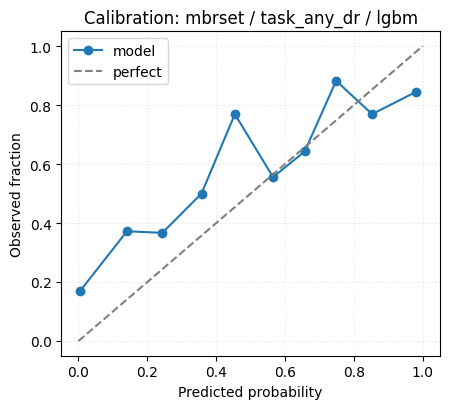

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\single_eval\calibration_mbrset_task_any_dr_lgbm.png
task_referable | model=xgb | ECE=0.1032 | Brier=0.1206


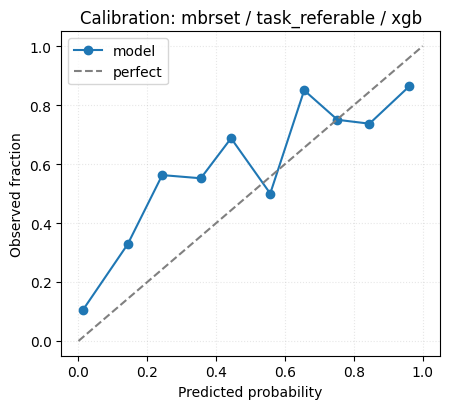

Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\single_eval\calibration_mbrset_task_referable_xgb.png

[skip] No device-like columns detected for device subgroup analysis.

=== Efficiency (fit/predict time, ops proxy): task_any_dr ===


,task,model,fit_time_s_mean,fit_time_s_std,predict_time_s_mean,predict_time_s_std,ops_proxy_per_sample
0,task_any_dr,logreg,0.500638,0.008920,0.008435,0.001568,1536.000000
1,task_any_dr,rf,1.417766,0.024838,0.122890,0.001992,21586.000000
2,task_any_dr,mlp,2.791901,0.425426,0.009219,0.000844,917760.000000
3,task_any_dr,xgb,44.883914,0.372708,0.013739,0.000416,15000.000000
4,task_any_dr,lgbm,29.218240,2.362947,0.022511,0.002504,23909.119694



=== Efficiency (fit/predict time, ops proxy): task_referable ===


,task,model,fit_time_s_mean,fit_time_s_std,predict_time_s_mean,predict_time_s_std,ops_proxy_per_sample
0,task_referable,logreg,0.484902,0.036885,0.010416,0.001276,1536.000000
1,task_referable,rf,1.371251,0.063607,0.135407,0.004059,21410.000000
2,task_referable,mlp,2.551615,0.289130,0.009455,0.000806,917760.000000
3,task_referable,xgb,44.223882,0.959733,0.014653,0.000850,15000.000000
4,task_referable,lgbm,25.844291,0.441239,0.021449,0.000738,23909.119694


Saved:
- c:\Users\Julian\OneDrive\Desktop\testing-retina-project\Retina-Project-Evaluation\main-project\results\single_eval\efficiency_mbrset_Embeddings_vit_base_mbrset.csv


In [4]:
# --- Step 2 add-ons: privacy, calibration, device slices, efficiency ---
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    brier_score_loss,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
 )
from pathlib import Path

import src.retina_evaluation as reval

if "df" not in globals() or "ds" not in globals():
    raise RuntimeError("Run Cell 1 and Cell 2 first to populate df/ds/summary_df/oof_df.")
if "summary_df" not in globals() or "oof_df" not in globals():
    raise RuntimeError("Run Cell 2 first to populate summary_df/oof_df.")

RESULTS_DIR = Path.cwd() / "results"
SINGLE_DIR = RESULTS_DIR / "single_eval"
SINGLE_DIR.mkdir(parents=True, exist_ok=True)

# --------------------
# Privacy-preserving checks (sex, age)
# --------------------
def _binary_metrics_local(y_true: np.ndarray, y_proba: np.ndarray, threshold: float = 0.5) -> dict[str, float]:
    y_true_i = y_true.astype(int)
    y_proba_f = y_proba.astype(np.float32)
    y_pred_i = (y_proba_f >= threshold).astype(int)
    out = {
        "n": float(len(y_true_i)),
        "pos_rate": float(y_true_i.mean()) if len(y_true_i) else np.nan,
        "accuracy": float(accuracy_score(y_true_i, y_pred_i)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true_i, y_pred_i)),
        "f1": float(f1_score(y_true_i, y_pred_i, zero_division=0)),
        "brier": float(brier_score_loss(y_true_i, y_proba_f)),
    }
    try:
        out["roc_auc"] = float(roc_auc_score(y_true_i, y_proba_f))
    except Exception:
        out["roc_auc"] = np.nan
    try:
        out["pr_auc"] = float(average_precision_score(y_true_i, y_proba_f))
    except Exception:
        out["pr_auc"] = np.nan
    return out


def _eval_sensitive_binary(*, label_col: str, model_names: list[str], n_splits: int = 5, seed: int = 0) -> pd.DataFrame:
    if label_col not in df.columns:
        print(f"[skip] Missing sensitive label: {label_col}")
        return pd.DataFrame()
    if "patient_id" not in df.columns:
        print("[skip] Missing patient_id; cannot do GroupKFold for privacy checks.")
        return pd.DataFrame()

    work = df.dropna(subset=[label_col, "patient_id"]).copy()
    y = work[label_col].astype(int).to_numpy()
    X_df = work.loc[:, ds.feature_cols].astype(np.float32)
    groups = work["patient_id"].astype(str).to_numpy()

    from sklearn.model_selection import GroupKFold
    gkf = GroupKFold(n_splits=n_splits)

    rows: list[dict[str, float]] = []
    for model_name in model_names:
        fold_metrics = []
        for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_df, y, groups=groups)):
            model = reval._make_model(model_name, random_state=seed + fold_idx)
            model.fit(X_df.iloc[train_idx], y[train_idx])
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(X_df.iloc[test_idx])[:, 1]
            else:
                scores = model.decision_function(X_df.iloc[test_idx])
                proba = 1.0 / (1.0 + np.exp(-scores))
            fold_metrics.append(_binary_metrics_local(y[test_idx], proba))
        fm = pd.DataFrame(fold_metrics)
        row = {"sensitive_label": label_col, "model": model_name}
        for k, v in fm.mean(numeric_only=True).items():
            row[f"{k}_mean"] = float(v)
        for k, v in fm.std(numeric_only=True).items():
            row[f"{k}_std"] = float(v)
        rows.append(row)
    out = pd.DataFrame(rows).sort_values(by="roc_auc_mean", ascending=False, na_position="last")
    return out


def _make_regressor(model_name: str, *, random_state: int = 0):
    name = model_name.lower()
    if name in {"logreg", "logistic", "logistic_regression", "lr"}:
        from sklearn.linear_model import Ridge
        return Ridge(alpha=1.0, random_state=random_state)
    if name in {"rf", "random_forest"}:
        from sklearn.ensemble import RandomForestRegressor
        return RandomForestRegressor(n_estimators=500, random_state=random_state, n_jobs=-1)
    if name in {"mlp", "mlp_sklearn"}:
        from sklearn.neural_network import MLPRegressor
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler
        return Pipeline(
            steps=[
                ("scaler", StandardScaler(with_mean=True, with_std=True)),
                (
                    "reg",
                    MLPRegressor(
                        hidden_layer_sizes=(512, 128),
                        activation="relu",
                        alpha=1e-4,
                        max_iter=300,
                        early_stopping=True,
                        n_iter_no_change=10,
                        random_state=random_state,
                    ),
                ),
            ],
        )
    if name in {"xgb", "xgboost"}:
        from xgboost import XGBRegressor
        return XGBRegressor(
            n_estimators=1500,
            learning_rate=0.03,
            max_depth=5,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            min_child_weight=1.0,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1,
            random_state=random_state,
        )
    if name in {"lgbm", "lightgbm"}:
        from lightgbm import LGBMRegressor
        return LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.03,
            num_leaves=63,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=0.0,
            verbose=-1,
            random_state=random_state,
            n_jobs=-1,
        )
    raise ValueError(f"Unknown regressor for: {model_name}")


def _eval_sensitive_regression(*, target_col: str, model_names: list[str], n_splits: int = 5, seed: int = 0) -> pd.DataFrame:
    if target_col not in df.columns:
        print(f"[skip] Missing sensitive target: {target_col}")
        return pd.DataFrame()
    if "patient_id" not in df.columns:
        print("[skip] Missing patient_id; cannot do GroupKFold for privacy checks.")
        return pd.DataFrame()

    work = df.dropna(subset=[target_col, "patient_id"]).copy()
    y = pd.to_numeric(work[target_col], errors="coerce").to_numpy()
    X_df = work.loc[:, ds.feature_cols].astype(np.float32)
    groups = work["patient_id"].astype(str).to_numpy()

    from sklearn.model_selection import GroupKFold
    gkf = GroupKFold(n_splits=n_splits)

    rows: list[dict[str, float]] = []
    for model_name in model_names:
        fold_metrics = []
        for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_df, y, groups=groups)):
            model = _make_regressor(model_name, random_state=seed + fold_idx)
            model.fit(X_df.iloc[train_idx], y[train_idx])
            preds = model.predict(X_df.iloc[test_idx])
            mae = mean_absolute_error(y[test_idx], preds)
            rmse = float(np.sqrt(mean_squared_error(y[test_idx], preds)))
            r2 = r2_score(y[test_idx], preds)
            fold_metrics.append({"mae": float(mae), "rmse": float(rmse), "r2": float(r2)})
        fm = pd.DataFrame(fold_metrics)
        row = {"sensitive_target": target_col, "model": model_name}
        for k, v in fm.mean(numeric_only=True).items():
            row[f"{k}_mean"] = float(v)
        for k, v in fm.std(numeric_only=True).items():
            row[f"{k}_std"] = float(v)
        rows.append(row)
    out = pd.DataFrame(rows).sort_values(by="mae_mean", ascending=True, na_position="last")
    return out


sensitive_reports = []

# Sex prediction (privacy check)
if "sex" in df.columns:
    sex_series = df["sex"].copy()
    if sex_series.dtype == object:
        sex_map = {"m": 1, "male": 1, "1": 1, 1: 1, "f": 0, "female": 0, "0": 0, 0: 0}
        sex_series = sex_series.astype(str).str.lower().map(sex_map)
    df["sex_bin"] = pd.to_numeric(sex_series, errors="coerce")
    sex_report = _eval_sensitive_binary(label_col="sex_bin", model_names=MODELS, n_splits=5, seed=0)
    if not sex_report.empty:
        print("\n=== Privacy: Sex prediction (using embeddings) ===")
        display(sex_report)
        sensitive_reports.append(sex_report)
else:
    print("[skip] No 'sex' column found for privacy prediction.")

# Age prediction (privacy check) -> regression
if "age" in df.columns:
    df["age"] = pd.to_numeric(df["age"], errors="coerce")
    age_report = _eval_sensitive_regression(target_col="age", model_names=MODELS, n_splits=5, seed=0)
    if not age_report.empty:
        print("\n=== Privacy: Age prediction (regression, in years) ===")
        display(age_report)
        sensitive_reports.append(age_report)
else:
    print("[skip] No 'age' column found for privacy prediction.")

if sensitive_reports:
    privacy_df = pd.concat(sensitive_reports, ignore_index=True)
    privacy_path = SINGLE_DIR / f"privacy_sensitive_predictions_{DATASET}_{EMBEDDINGS_CSV.stem}.csv"
    privacy_df.to_csv(privacy_path, index=False)
    print("Saved:")
    print("-", privacy_path)

# --------------------
# Calibration + uncertainty for disease models (OOF-based)
# --------------------
def _ece_score(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    y_true = y_true.astype(int)
    y_prob = y_prob.astype(float)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (np.abs(acc - conf) * mask.mean())
    return float(ece)


print("\n=== Calibration (OOF) for disease models ===")
for task in TASKS:
    task_oof = oof_df[oof_df["label_col"] == task].copy()
    if task_oof.empty:
        continue
    best = (
        summary_df[summary_df["task"] == task]
        .sort_values(by="roc_auc_mean", ascending=False, na_position="last")
        .iloc[0]["model"]
    )
    sub = task_oof[task_oof["model"] == best].dropna(subset=["y_true", "y_proba"])
    if sub.empty:
        continue
    y_true = sub["y_true"].astype(int).to_numpy()
    y_prob = sub["y_proba"].astype(float).to_numpy()
    ece = _ece_score(y_true, y_prob, n_bins=10)
    brier = float(brier_score_loss(y_true, y_prob))
    print(f"{task} | model={best} | ECE={ece:.4f} | Brier={brier:.4f}")

    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure(figsize=(4.6, 4.2))
    plt.plot(mean_pred, frac_pos, marker="o", label="model")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="perfect")
    plt.title(f"Calibration: {DATASET} / {task} / {best}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction")
    plt.grid(alpha=0.3, linestyle=":")
    plt.legend()
    plt.tight_layout()
    cal_path = SINGLE_DIR / f"calibration_{DATASET}_{task}_{best}.png"
    plt.savefig(cal_path, dpi=160)
    plt.show()
    print("Saved:")
    print("-", cal_path)

# --------------------
# Fairness slices by device (if any device-like column exists)
# --------------------
def _find_device_cols(cols: list[str]) -> list[str]:
    keys = ["device", "camera", "scanner", "machine", "instrument", "model"]
    out = []
    for c in cols:
        lc = c.lower()
        if any(k in lc for k in keys):
            out.append(c)
    return out


def _subgroup_report_any(oof: pd.DataFrame, model_name: str, by: str) -> pd.DataFrame:
    sub = oof[oof["model"] == model_name].copy()
    if by not in sub.columns:
        return pd.DataFrame()
    rows = []
    for group_val, g in sub.groupby(by):
        g = g.dropna(subset=["y_true", "y_proba"])
        if g.empty:
            continue
        y_true = g["y_true"].astype(int).to_numpy()
        y_prob = g["y_proba"].astype(float).to_numpy()
        y_pred = (y_prob >= 0.5).astype(int)
        row = {
            by: group_val,
            "n": float(len(g)),
            "pos_rate": float(y_true.mean()) if len(g) else np.nan,
            "accuracy": float(accuracy_score(y_true, y_pred)),
            "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
            "f1": float(f1_score(y_true, y_pred, zero_division=0)),
            "brier": float(brier_score_loss(y_true, y_prob)),
        }
        try:
            row["roc_auc"] = float(roc_auc_score(y_true, y_prob))
        except Exception:
            row["roc_auc"] = np.nan
        try:
            row["pr_auc"] = float(average_precision_score(y_true, y_prob))
        except Exception:
            row["pr_auc"] = np.nan
        rows.append(row)
    return pd.DataFrame(rows).sort_values(by="roc_auc", ascending=False, na_position="last")


device_cols = _find_device_cols(list(df.columns))
if device_cols:
    print("\n=== Device subgroup analysis (if available) ===")
    device_tables = []
    for task in TASKS:
        task_oof = oof_df[oof_df["label_col"] == task]
        best = (
            summary_df[summary_df["task"] == task]
            .sort_values(by="roc_auc_mean", ascending=False, na_position="last")
            .iloc[0]["model"]
        )
        for dcol in device_cols:
            if dcol not in task_oof.columns and dcol in df.columns:
                task_oof = task_oof.copy()
                task_oof[dcol] = df.loc[task_oof.index, dcol].to_numpy()
            report = _subgroup_report_any(task_oof, model_name=best, by=dcol)
            if not report.empty:
                report.insert(0, "task", task)
                report.insert(1, "model", best)
                report.insert(2, "device_col", dcol)
                print(f"\n{task} / {dcol} (best model: {best})")
                display(report)
                device_tables.append(report)
    if device_tables:
        device_df = pd.concat(device_tables, ignore_index=True)
        device_path = SINGLE_DIR / f"device_subgroups_{DATASET}_{EMBEDDINGS_CSV.stem}.csv"
        device_df.to_csv(device_path, index=False)
        print("Saved:")
        print("-", device_path)
else:
    print("\n[skip] No device-like columns detected for device subgroup analysis.")

# --------------------
# Efficiency: fit time, predict time, and a simple ops proxy
# --------------------
def _unwrap_estimator(model):
    if hasattr(model, "steps") and len(model.steps) > 0:
        return model.steps[-1][1]
    return model


def _ops_proxy_per_sample(model, n_features: int) -> float:
    est = _unwrap_estimator(model)
    name = est.__class__.__name__.lower()
    if "logisticregression" in name:
        return float(2 * n_features)
    if "mlp" in name and hasattr(est, "coefs_"):
        total = 0
        for w in est.coefs_:
            total += 2 * w.shape[0] * w.shape[1]
        return float(total)
    if "randomforest" in name and hasattr(est, "estimators_"):
        depths = [t.tree_.max_depth for t in est.estimators_ if hasattr(t, "tree_")]
        if depths:
            return float(2 * np.mean(depths) * len(depths))
    if "xgb" in name and hasattr(est, "n_estimators"):
        max_depth = getattr(est, "max_depth", 6) or 6
        return float(2 * est.n_estimators * max_depth)
    if "lgbm" in name and hasattr(est, "n_estimators"):
        num_leaves = getattr(est, "num_leaves", 31) or 31
        depth = np.log2(num_leaves)
        return float(2 * est.n_estimators * depth)
    return np.nan


def _efficiency_report(task_col: str, model_names: list[str], n_splits: int = 5, seed: int = 0) -> pd.DataFrame:
    if task_col not in df.columns:
        return pd.DataFrame()
    work = df.dropna(subset=[task_col, "patient_id"]).copy()
    y = work[task_col].astype(int).to_numpy()
    groups = work["patient_id"].astype(str).to_numpy()
    X_df = work.loc[:, ds.feature_cols].astype(np.float32)
    n_features = X_df.shape[1]

    from sklearn.model_selection import GroupKFold
    gkf = GroupKFold(n_splits=n_splits)

    rows = []
    for model_name in model_names:
        fit_times = []
        pred_times = []
        ops_proxy = np.nan
        for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_df, y, groups=groups)):
            model = reval._make_model(model_name, random_state=seed + fold_idx)
            t0 = time.perf_counter()
            model.fit(X_df.iloc[train_idx], y[train_idx])
            t1 = time.perf_counter()
            if np.isnan(ops_proxy):
                ops_proxy = _ops_proxy_per_sample(model, n_features=n_features)
            if hasattr(model, "predict_proba"):
                _ = model.predict_proba(X_df.iloc[test_idx])[:, 1]
            else:
                _ = model.decision_function(X_df.iloc[test_idx])
            t2 = time.perf_counter()
            fit_times.append(t1 - t0)
            pred_times.append(t2 - t1)
        rows.append({
            "task": task_col,
            "model": model_name,
            "fit_time_s_mean": float(np.mean(fit_times)),
            "fit_time_s_std": float(np.std(fit_times)),
            "predict_time_s_mean": float(np.mean(pred_times)),
            "predict_time_s_std": float(np.std(pred_times)),
            "ops_proxy_per_sample": float(ops_proxy) if not np.isnan(ops_proxy) else np.nan,
        })
    return pd.DataFrame(rows)


eff_parts = []
for task in TASKS:
    eff = _efficiency_report(task, model_names=MODELS, n_splits=5, seed=0)
    if not eff.empty:
        eff_parts.append(eff)
        print(f"\n=== Efficiency (fit/predict time, ops proxy): {task} ===")
        display(eff)

if eff_parts:
    eff_df = pd.concat(eff_parts, ignore_index=True)
    eff_path = SINGLE_DIR / f"efficiency_{DATASET}_{EMBEDDINGS_CSV.stem}.csv"
    eff_df.to_csv(eff_path, index=False)
    print("Saved:")
    print("-", eff_path)
